# Multi-File Linguistic Analysis - Dementia Dataset
This notebook processes JSON files from the dementia folder and performs linguistic analysis on character memory retellings across different ages. Each file contains a character's stories at different ages along with their deterioration onset age.

## Import Required Libraries

In [ ]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [ ]:
# import linguistic feature extraction functions
from utils.extract_nlp_features import (
    nouns_freq_in_text,
    word_used_once_frequency,
    word_used_once_or_twice_frequency,
    brunet_index,
    token_type_ratio,
    adposition_frequency,
    uni_and_bi_grams_repetitions,
    word_freq_subtl,
    word_freq_zipf
)

## Load All JSON Files from Dementia Folder

In [3]:
def load_json_files_from_folder(folder_path):
    """Load all JSON files from a specified folder."""
    json_files = glob.glob(os.path.join(folder_path, "*.json"))
    all_data = []

    for file_path in json_files:
        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                data = json.load(file)
                all_data.append(data)
                character_name = data.get('name', 'Unknown')
                start_deterioration_age = data.get(
                    'start_deterioration_age', 'Unknown')
                print(
                    f"Loaded: {os.path.basename(file_path)} - Character: {character_name} - Start deterioration age: {start_deterioration_age}")
        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    return all_data


# Load all JSON files from the dementia data folder
data_folder = "stories/data_oct_6/healthyAging"
all_character_data = load_json_files_from_folder(data_folder)

print(f"\nLoaded {len(all_character_data)} character files.")

Loaded: mark-edward-thompson.json - Character: Mark Edward Thompson - Start deterioration age: 60
Loaded: olivia-margaret-chen.json - Character: Olivia Margaret Chen - Start deterioration age: 60
Loaded: lisa-carmen-alvarez.json - Character: Lisa Carmen Alvarez - Start deterioration age: 60
Loaded: jessica-marie-holloway.json - Character: Jessica Marie Holloway - Start deterioration age: 60
Loaded: keren-aliza-hadar.json - Character: Keren Aliza Hadar - Start deterioration age: 60
Loaded: jacob-stein.json - Character: Jacob Stein - Start deterioration age: 60
Loaded: robert-elias-garner.json - Character: Robert Elias Garner - Start deterioration age: 60
Loaded: anthony-samuel-reyes.json - Character: Anthony Samuel Reyes - Start deterioration age: 60
Loaded: george-leonard.json - Character: George Leonard - Start deterioration age: 60
Loaded: james-whitaker.json - Character: James Whitaker - Start deterioration age: 60

Loaded 10 character files.


## Aggregate Retellings Across All Files

In [4]:
def aggregate_stories_with_years_before_diagnostic(all_character_data):
    """
    Combine all stories from all characters and calculate years before diagnostic.
    Each story becomes a data point with its years before diagnostic based on individual character's start_deterioration_age.
    """
    all_story_points = []

    for character_data in all_character_data:
        character_name = character_data.get('name', 'Unknown')
        stories = character_data.get('stories', [])
        deterioration_age = character_data.get('start_deterioration_age')

        if deterioration_age is None:
            print(
                f"Warning: No deterioration age found for {character_name}, skipping...")
            continue

        for story_data in stories:
            age = story_data.get('age')
            story = story_data.get('story', '')
            if age is not None and story:
                years_before_diagnostic = -(deterioration_age - age)
                all_story_points.append({
                    'character': character_name,
                    'age': age,
                    'deterioration_age': deterioration_age,
                    'years_before_diagnostic': years_before_diagnostic,
                    'story': story
                })

    return all_story_points


# Aggregate all stories with years before diagnostic calculation using individual deterioration ages
all_story_data = aggregate_stories_with_years_before_diagnostic(
    all_character_data)

# Display summary
print(f"Total story data points: {len(all_story_data)}")
if all_story_data:
    years_before_range = [point['years_before_diagnostic']
                          for point in all_story_data]
    print(
        f"Years before diagnostic range: {min(years_before_range)} to {max(years_before_range)}")

    # Show sample data points
    print(f"\nSample data points:")
    for i, point in enumerate(all_story_data[:5]):
        print(f"  {point['character']} - Age {point['age']} (deterioration starts at {point['deterioration_age']}) -> {point['years_before_diagnostic']} years before diagnostic")
        print(f"    Story length: {len(point['story'])} characters")

    # Show distribution by character
    character_counts = {}
    for point in all_story_data:
        char = point['character']
        character_counts[char] = character_counts.get(char, 0) + 1

    print(f"\nStory distribution by character:")
    for char, count in character_counts.items():
        # Get deterioration age from the original data
        deterioration_age = next((data['start_deterioration_age']
                                 for data in all_character_data if data.get('name') == char), 'Unknown')
        print(
            f"  {char}: {count} stories (deterioration starts at age {deterioration_age})")
else:
    print("No story data found!")

Total story data points: 60
Years before diagnostic range: 0 to 15

Sample data points:
  Mark Edward Thompson - Age 60 (deterioration starts at 60) -> 0 years before diagnostic
    Story length: 612 characters
  Mark Edward Thompson - Age 63 (deterioration starts at 60) -> 3 years before diagnostic
    Story length: 553 characters
  Mark Edward Thompson - Age 66 (deterioration starts at 60) -> 6 years before diagnostic
    Story length: 571 characters
  Mark Edward Thompson - Age 69 (deterioration starts at 60) -> 9 years before diagnostic
    Story length: 491 characters
  Mark Edward Thompson - Age 72 (deterioration starts at 60) -> 12 years before diagnostic
    Story length: 421 characters

Story distribution by character:
  Mark Edward Thompson: 6 stories (deterioration starts at age 60)
  Olivia Margaret Chen: 6 stories (deterioration starts at age 60)
  Lisa Carmen Alvarez: 6 stories (deterioration starts at age 60)
  Jessica Marie Holloway: 6 stories (deterioration starts at a

## Plotting Utility Function

In [ ]:
def plot_scatter_with_regression(story_data, metric_function, label_y: str, title_suffix: str = ""):
    """Plot scatter plot of individual stories with linear regression trend line."""
    if not story_data:
        print(f"No data available for {label_y}")
        return

    # Calculate metric for each story
    x_values = []  # years before diagnostic
    y_values = []  # metric values
    characters = []

    for story_point in story_data:
        metric_value = metric_function(story_point['story'])
        x_values.append(story_point['years_before_diagnostic'])
        y_values.append(metric_value)
        characters.append(story_point['character'])

    if not x_values:
        print(f"No valid data points for {label_y}")
        return

    plt.figure(figsize=(12, 8))

    # Create scatter plot with different colors for each character
    unique_characters = list(set(characters))
    colors = plt.cm.tab10(range(len(unique_characters)))

    for i, character in enumerate(unique_characters):
        char_mask = [c == character for c in characters]
        char_x = [x for x, mask in zip(x_values, char_mask) if mask]
        char_y = [y for y, mask in zip(y_values, char_mask) if mask]

        plt.scatter(char_x, char_y, alpha=0.7, s=60,
                    color=colors[i], label=character, edgecolors='black', linewidth=0.5)

    # Add linear regression trend line
    if len(x_values) > 1:
        z = np.polyfit(x_values, y_values, 1)
        p = np.poly1d(z)
        x_trend = np.linspace(min(x_values), max(x_values), 100)
        plt.plot(x_trend, p(x_trend), "r--", alpha=0.8,
                 linewidth=2, label='Linear Trend')

        # Calculate and display correlation coefficient and p-value
        correlation, p_value = stats.pearsonr(x_values, y_values)
        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"

        plt.text(0.02, 0.98, f'Correlation: {correlation:.3f} ({significance})\np-value: {p_value:.4f}',
                 transform=plt.gca().transAxes, fontsize=10,
                 verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    # Standardize x-axis ticks and limits
    plt.xlim(-16, 10)
    plt.xticks(range(-15, 10, 3))
    plt.xlabel('Years Before Diagnostic', fontsize=12)
    plt.ylabel(f'{label_y}', fontsize=12)
    plt.title(f'{label_y} vs Years Before Diagnostic{title_suffix}',
              fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

## Nouns freq by deterioration age

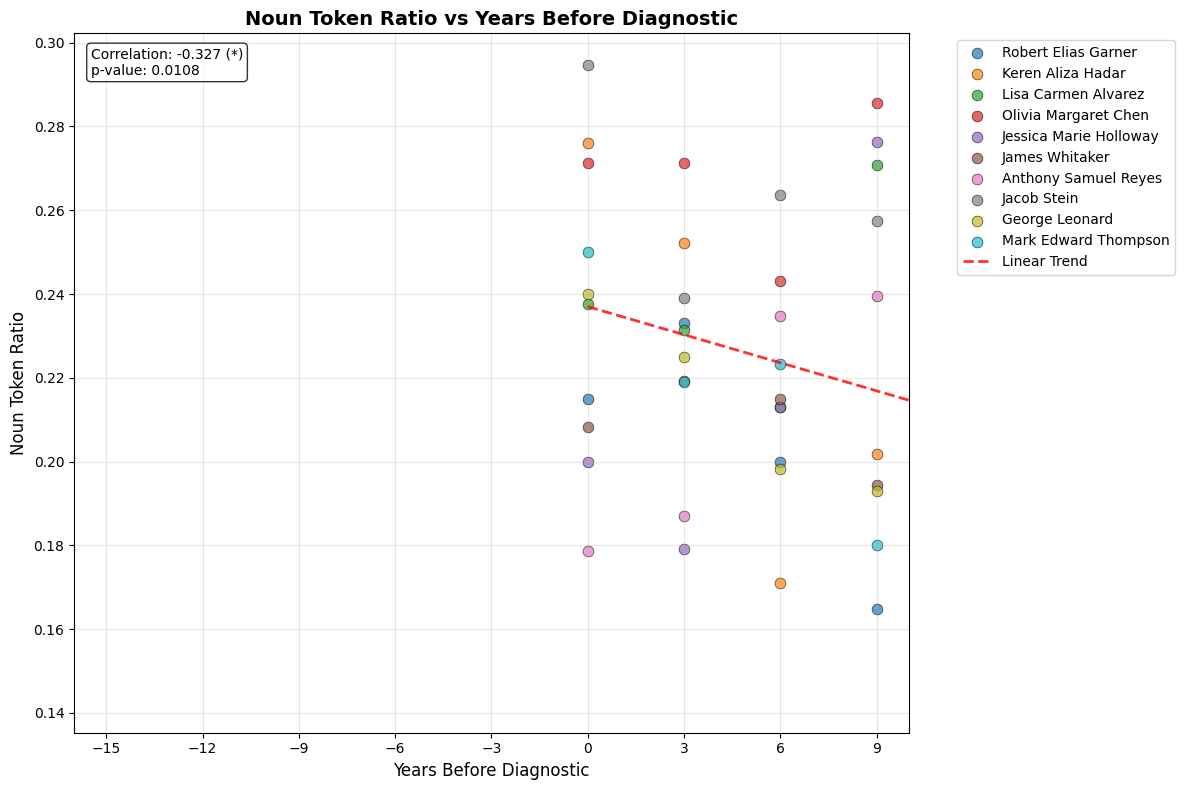

In [7]:
# Plot noun token ratio scatter plot
plot_scatter_with_regression(
    all_story_data, nouns_freq_in_text, "Noun Token Ratio")

## Calculate Hapax Legomena Frequency by Age

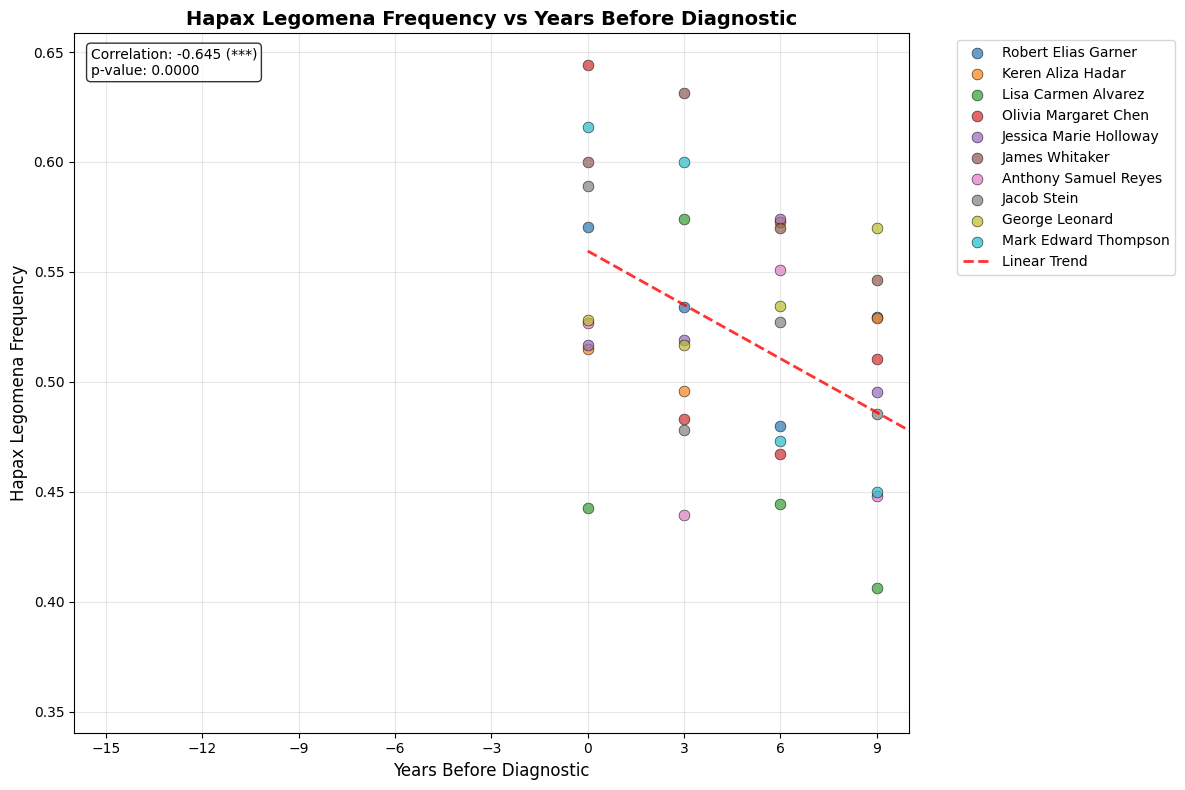

In [8]:
# Plot hapax legomena frequency scatter plot
plot_scatter_with_regression(
    all_story_data, word_used_once_frequency, "Hapax Legomena Frequency")

## Calculate Words Used Once or Twice Frequency by Age

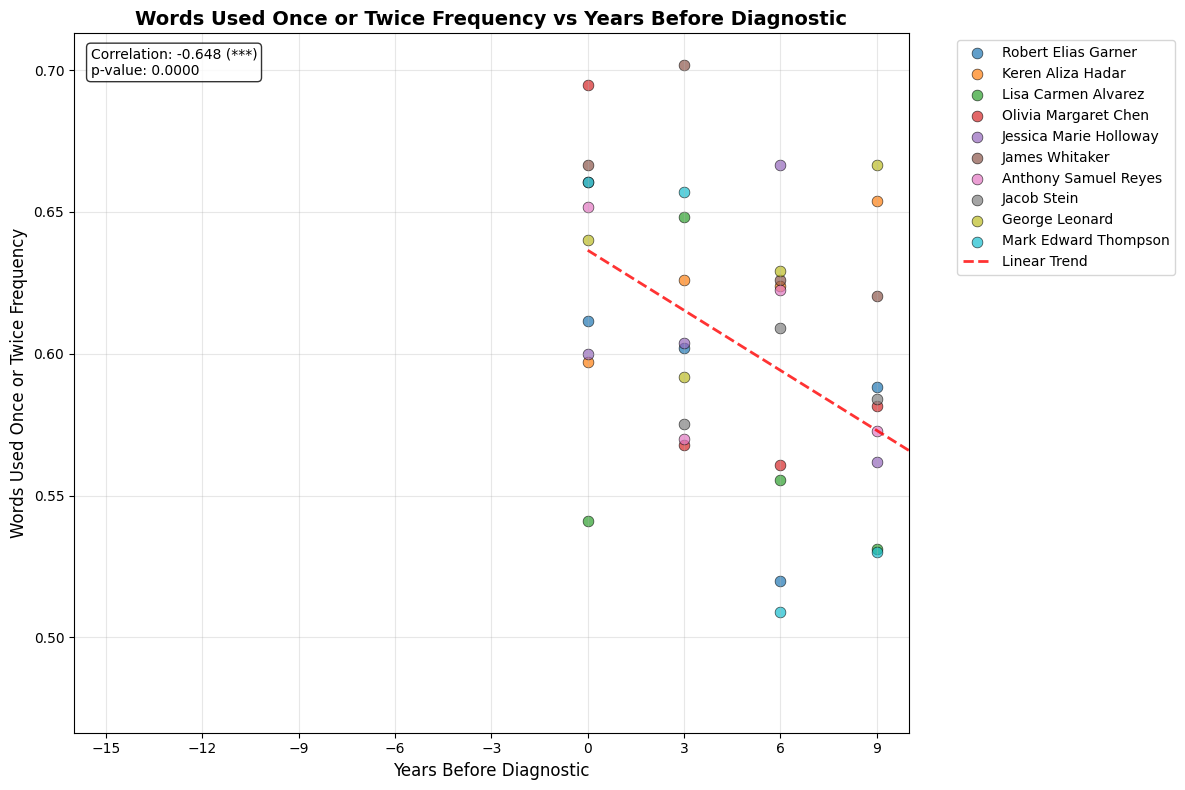

In [9]:
# Plot words used once or twice frequency scatter plot
plot_scatter_with_regression(
    all_story_data, word_used_once_or_twice_frequency, "Words Used Once or Twice Frequency")

## Calculate Brunet Index by Age

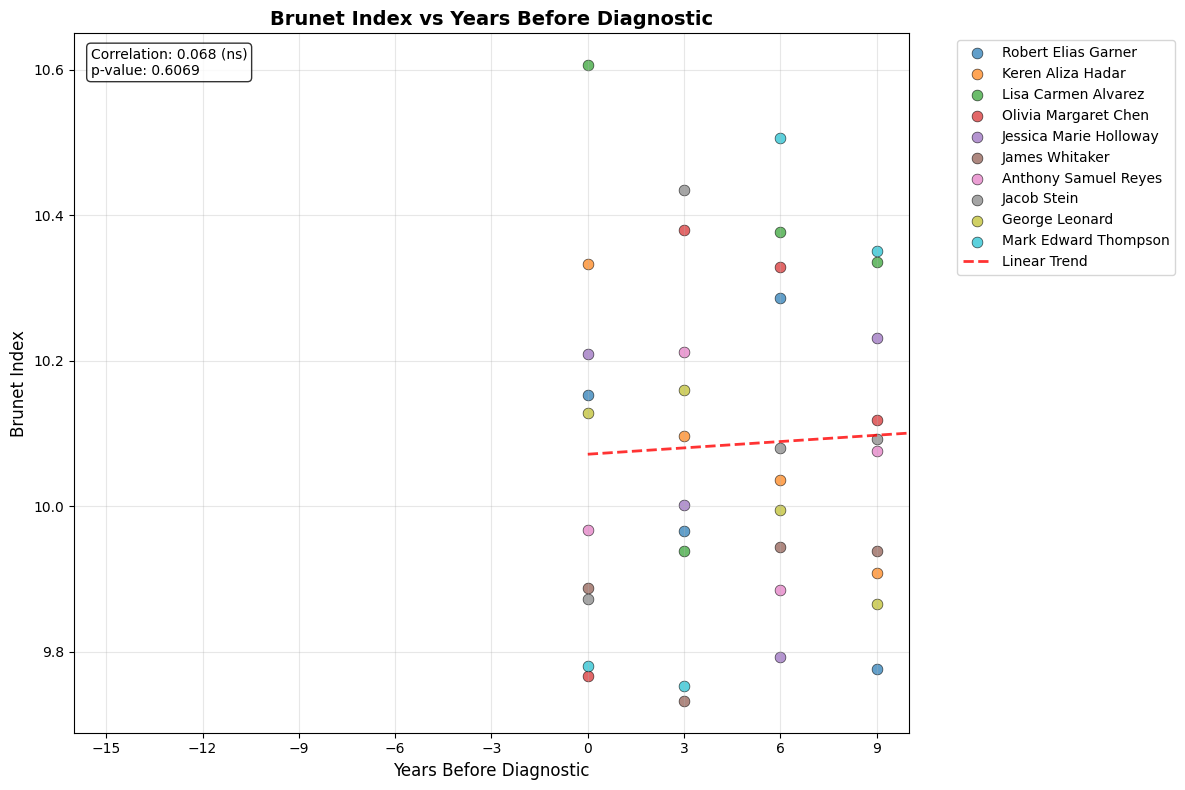

In [10]:
# Plot Brunet index scatter plot
plot_scatter_with_regression(all_story_data, brunet_index, "Brunet Index")

## Calculate Type-Token Ratio by Age

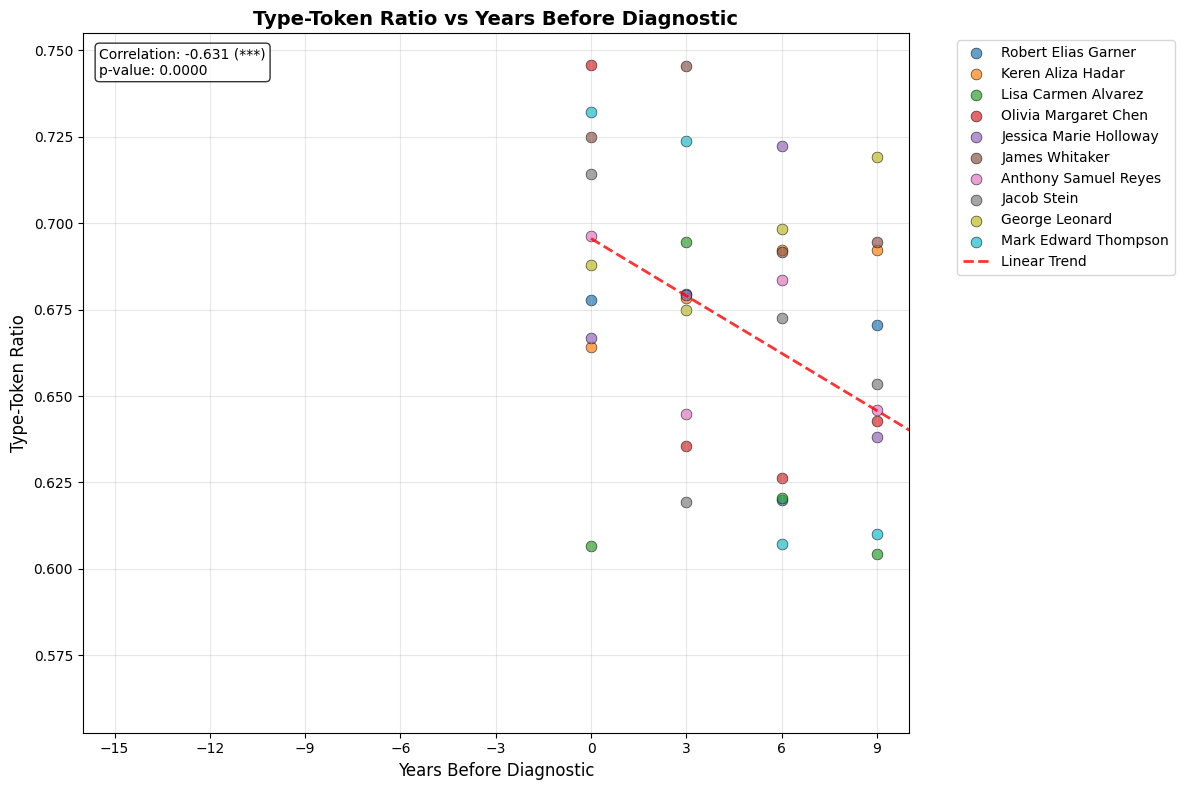

In [11]:
# Plot type-token ratio scatter plot
plot_scatter_with_regression(
    all_story_data, token_type_ratio, "Type-Token Ratio")

## Calculate Adposition Frequency by Age

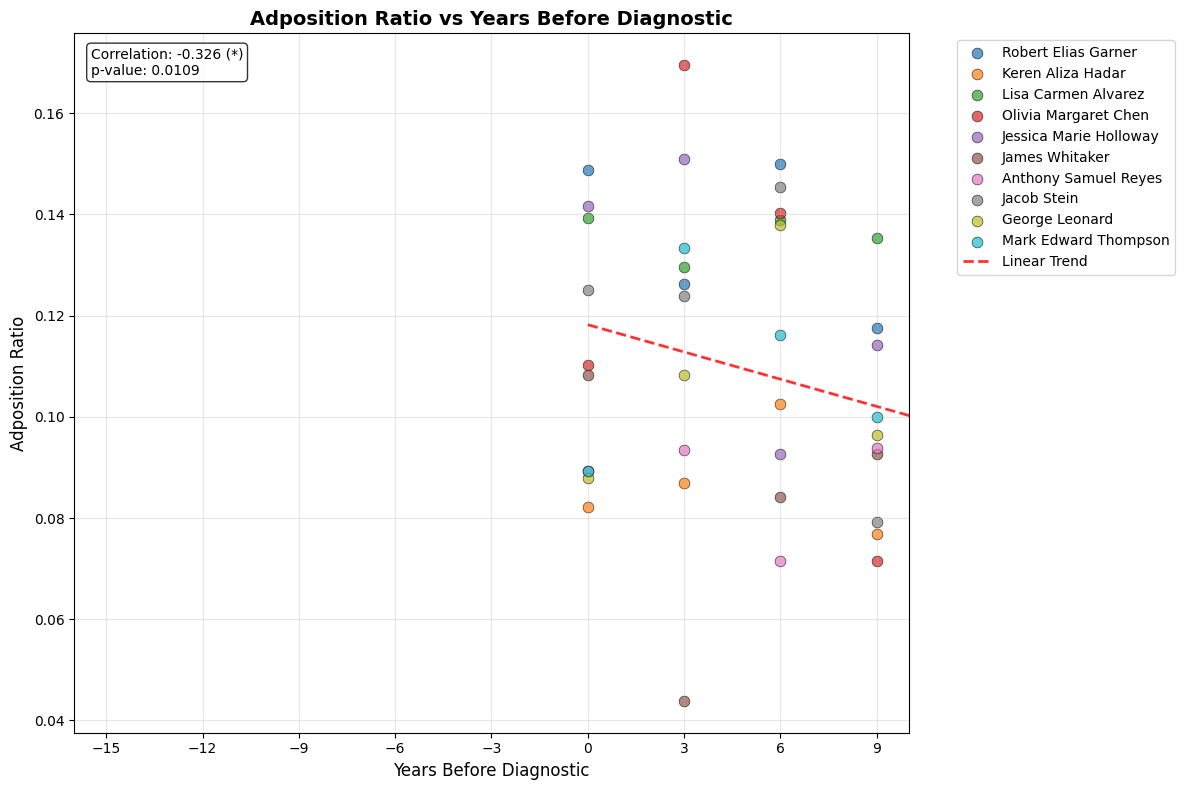

In [12]:
# Plot adposition ratio scatter plot
plot_scatter_with_regression(
    all_story_data, adposition_frequency, "Adposition Ratio")

## Calculate Unigram and Bigram Repetitions by Age

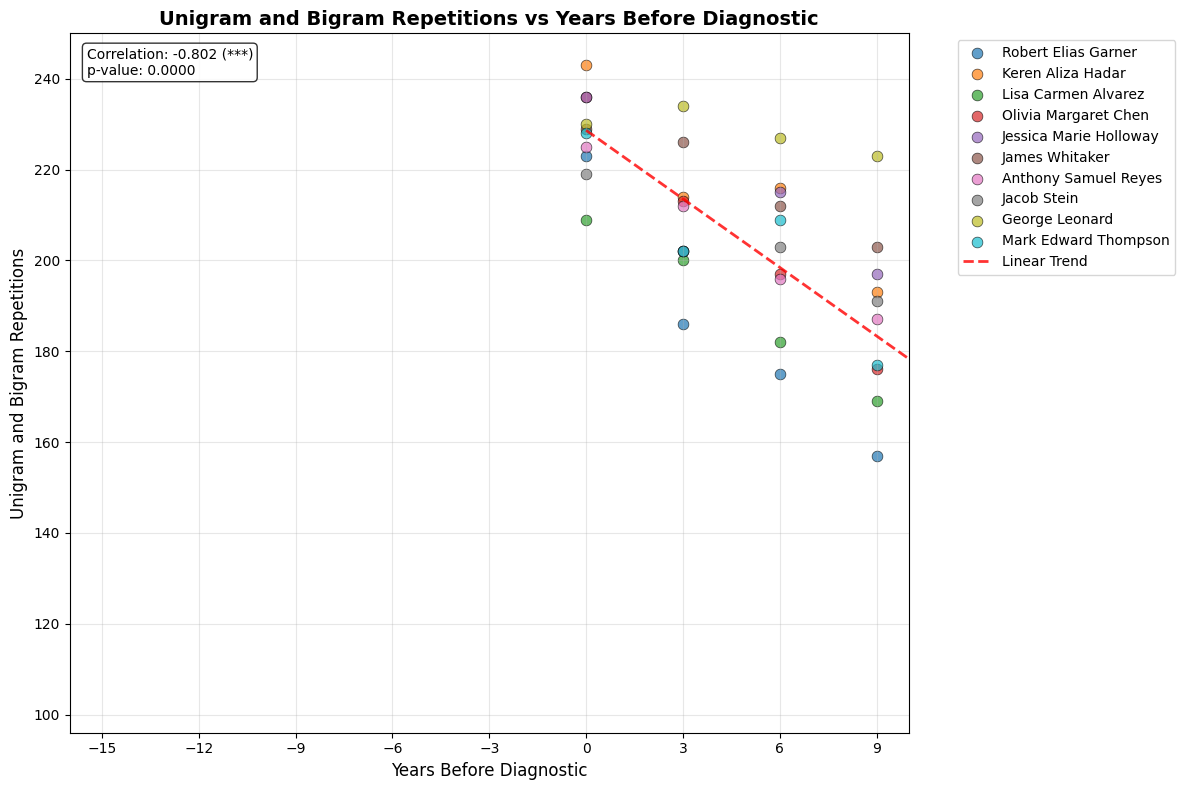

In [13]:
# Plot unigram and bigram repetitions scatter plot
plot_scatter_with_regression(
    all_story_data, uni_and_bi_grams_repetitions, "Unigram and Bigram Repetitions")

## Load Word Frequency Data (CSV)

In [14]:
def load_csv(file_path):
    """Load a CSV file and return its content."""
    return pd.read_csv(file_path)


# Load word frequency data
try:
    subtl_and_zipf_df = load_csv('subtl_and_zipf.csv')
    # Filter relevant columns
    subtl_and_zipf_df = subtl_and_zipf_df[[
        'Word', 'FREQcount', 'SUBTLWF', 'Zipf-value']]
    print("Successfully loaded word frequency data.")
    print(f"Shape: {subtl_and_zipf_df.shape}")
    print(subtl_and_zipf_df.describe())
except FileNotFoundError:
    print("Warning: subtl_and_zipf.csv not found. Skipping frequency analysis.")
    subtl_and_zipf_df = None

Successfully loaded word frequency data.
Shape: (74286, 4)
          FREQcount       SUBTLWF    Zipf-value
count  7.428600e+04  74286.000000  74286.000000
mean   6.692992e+02     13.124088      2.479172
std    1.727704e+04    338.765454      0.835829
min    1.000000e+00      0.020000      1.592864
25%    2.000000e+00      0.040000      1.768955
50%    9.000000e+00      0.180000      2.291834
75%    4.500000e+01      0.880000      2.954592
max    2.134713e+06  41857.120000      7.621174


## Calculate SUBTLEX Frequency by Age

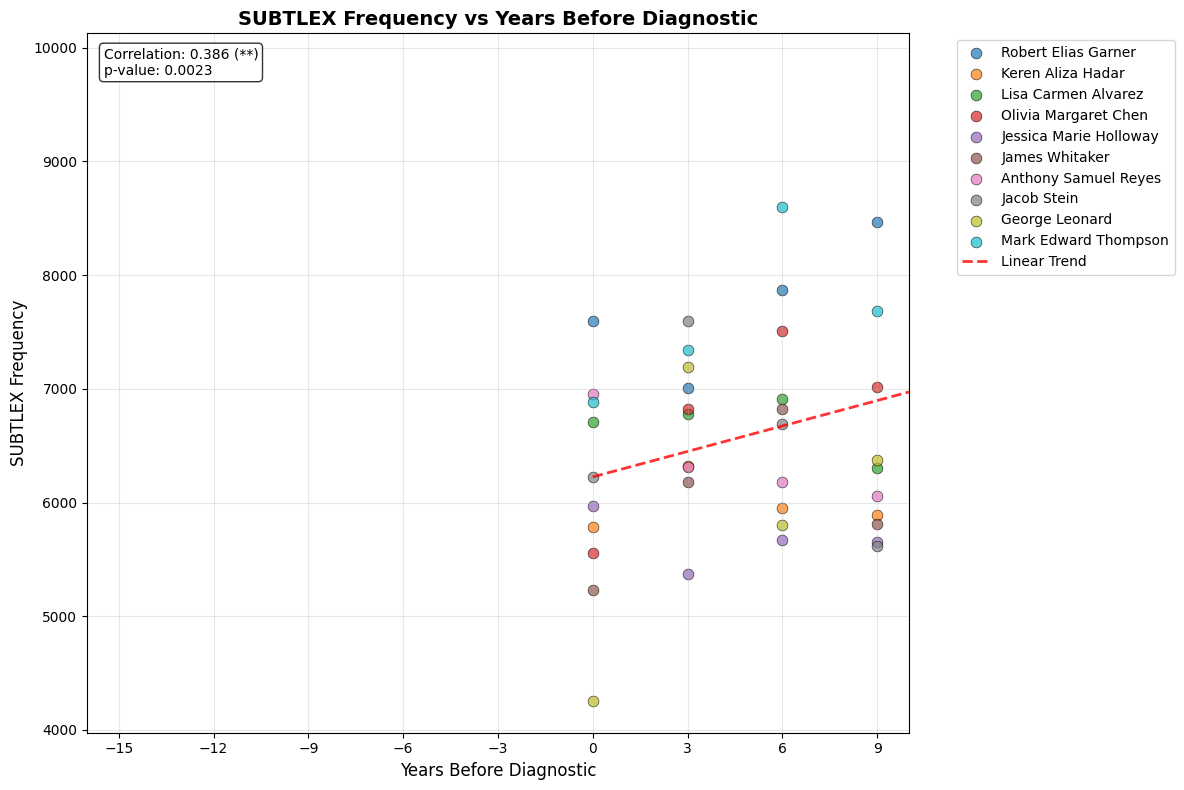

In [15]:
# Plot SUBTLEX frequency scatter plot
if subtl_and_zipf_df is not None:
    def subtl_metric(text):
        return word_freq_subtl(text, subtl_and_zipf_df)

    plot_scatter_with_regression(
        all_story_data, subtl_metric, "SUBTLEX Frequency")
else:
    print("Skipping SUBTLEX frequency analysis due to missing data.")

## Calculate Zipf Frequency by Age

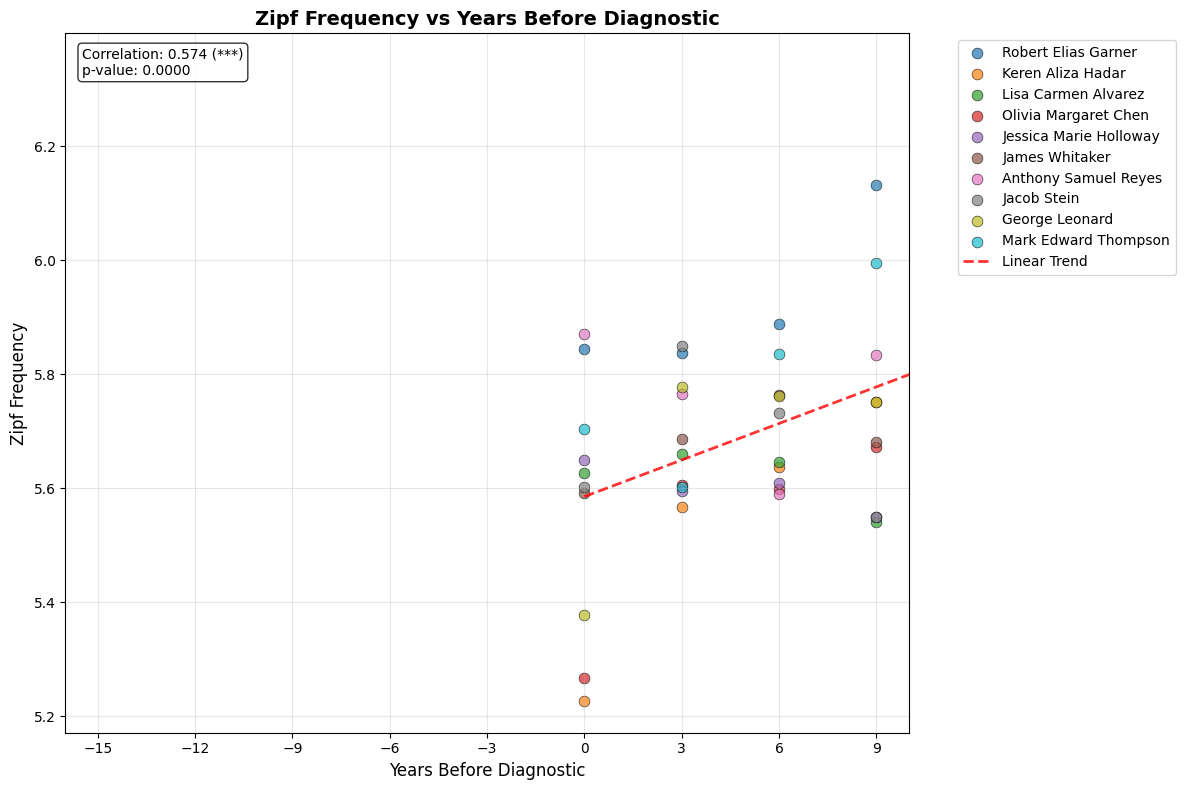

In [16]:
# Plot Zipf frequency scatter plot
if subtl_and_zipf_df is not None:
    def zipf_metric(text):
        return word_freq_zipf(text, subtl_and_zipf_df)

    plot_scatter_with_regression(all_story_data, zipf_metric, "Zipf Frequency")
else:
    print("Skipping Zipf frequency analysis due to missing data.")

## Comprehensive Visualization - All Metrics

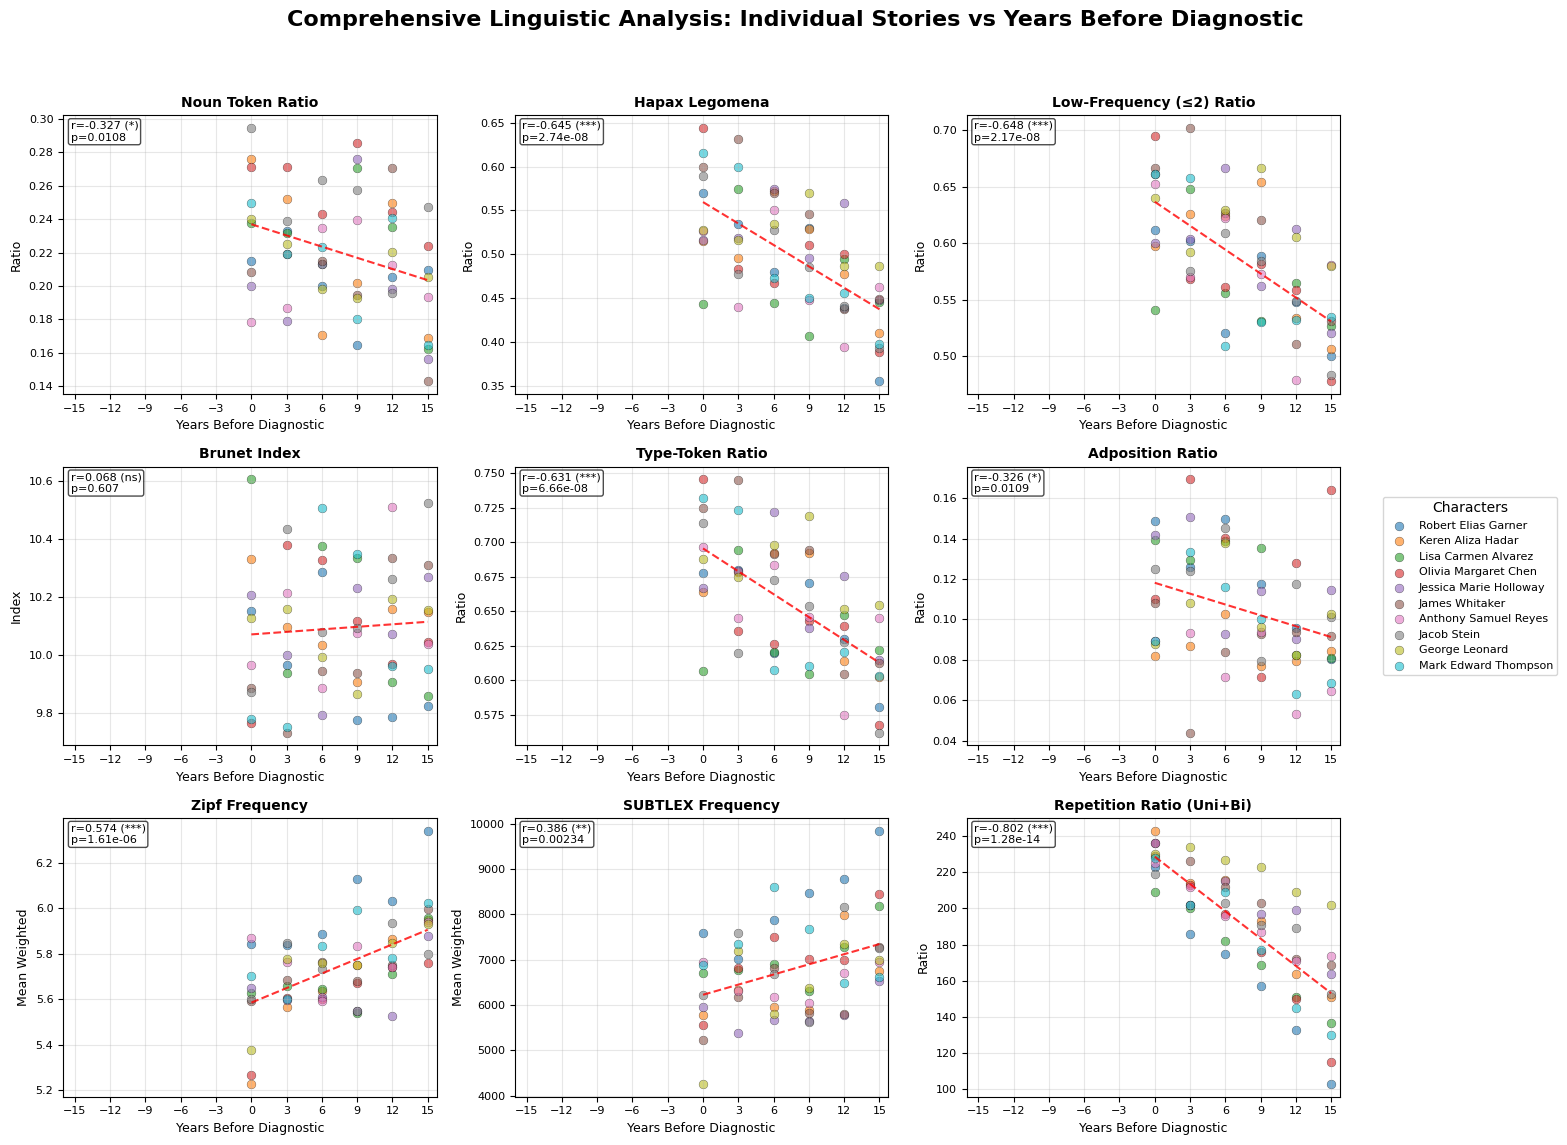

In [18]:
def create_comprehensive_scatter_plot():
    """Create a comprehensive 3x3 subplot showing all linguistic metrics as scatter plots."""
    # Prepare the metric functions (updated labels)
    metric_functions = [
        (nouns_freq_in_text, "Noun Token Ratio", "Ratio"),
        (word_used_once_frequency, "Hapax Legomena", "Ratio"),
        (word_used_once_or_twice_frequency, "Low-Frequency (≤2) Ratio", "Ratio"),
        (brunet_index, "Brunet Index", "Index"),
        (token_type_ratio, "Type-Token Ratio", "Ratio"),
        (adposition_frequency, "Adposition Ratio", "Ratio"),
        (uni_and_bi_grams_repetitions, "Repetition Ratio (Uni+Bi)", "Ratio"),
    ]

    # Add frequency metrics if available (Zipf & SUBTLEX) before repetition ratio for readability
    if subtl_and_zipf_df is not None:
        def zipf_metric(text):
            return word_freq_zipf(text, subtl_and_zipf_df)

        def subtl_metric(text):
            return word_freq_subtl(text, subtl_and_zipf_df)
        metric_functions.insert(
            6, (subtl_metric, "SUBTLEX Frequency", "Mean Weighted"))
        metric_functions.insert(
            6, (zipf_metric, "Zipf Frequency", "Mean Weighted"))

    fig, axes = plt.subplots(3, 3, figsize=(16, 12))
    fig.suptitle('Comprehensive Linguistic Analysis: Individual Stories vs Years Before Diagnostic',
                 fontsize=16, fontweight='bold')

    all_characters = list(set(point['character'] for point in all_story_data))
    colors = plt.cm.tab10(range(len(all_characters)))
    character_colors = dict(zip(all_characters, colors))

    for i, (metric_function, title, ylabel) in enumerate(metric_functions):
        row = i // 3
        col = i % 3
        ax = axes[row, col]

        x_values = []
        y_values = []
        characters = []
        for story_point in all_story_data:
            try:
                metric_value = metric_function(story_point['story'])
                x_values.append(story_point['years_before_diagnostic'])
                y_values.append(metric_value)
                characters.append(story_point['character'])
            except Exception:
                continue

        if x_values:
            for character in all_characters:
                char_mask = [c == character for c in characters]
                char_x = [x for x, mask in zip(x_values, char_mask) if mask]
                char_y = [y for y, mask in zip(y_values, char_mask) if mask]
                if char_x:
                    ax.scatter(char_x, char_y, alpha=0.6, s=40,
                               color=character_colors[character], label=character,
                               edgecolors='black', linewidth=0.3)
            if len(x_values) > 1:
                try:
                    z = np.polyfit(x_values, y_values, 1)
                    p = np.poly1d(z)
                    x_trend = np.linspace(min(x_values), max(x_values), 100)
                    ax.plot(x_trend, p(x_trend), "r--",
                            alpha=0.8, linewidth=1.5)
                    r, p_val = stats.pearsonr(x_values, y_values)
                    sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
                    ax.text(0.02, 0.98, f'r={r:.3f} ({sig})\np={p_val:.3g}',
                            transform=ax.transAxes, fontsize=8,
                            verticalalignment='top',
                            bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.7))
                except Exception:
                    pass
            ax.set_xlabel('Years Before Diagnostic', fontsize=9)
            ax.set_ylabel(ylabel, fontsize=9)
            ax.set_title(title, fontsize=10, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.tick_params(labelsize=8)
            ax.set_xticks(np.arange(-15, max(x_values)+1, 3))
            ax.set_xlim(left=-16)
        else:
            ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center', transform=ax.transAxes,
                    fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
            ax.set_title(title, fontsize=10, fontweight='bold')
            ax.set_xlabel('Years Before Diagnostic', fontsize=9)
            ax.set_ylabel(ylabel, fontsize=9)

    handles, labels = axes[0, 0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.98, 0.5),
                   title='Characters', title_fontsize=10, fontsize=8)

    plt.tight_layout(rect=[0, 0.03, 0.85, 0.95])
    plt.show()


# Create the comprehensive scatter plot visualization
create_comprehensive_scatter_plot()